# Making Bibliographies Computable 

Independent study by Saahil Hiranandani

In [1]:
import pandas as pd
import numpy as np

After running data_extraction.py we get a extracted_scopus_data.csv file which contains information about all searched papers.

In [2]:
searched_data = pd.DataFrame(pd.read_csv("data/extracted_scopus_data.csv", header=0))
searched_data

,Title,Abstract,Number of results,Reference Titles,Authors
0,Human Influenza Resulting from Aerosol Inhalation,Volunteers were given A2 influenza virus in a ...,1,[],"['Robert H. Alford', 'Julius A. Kasel', 'Peter..."
1,Influenza A virus is transmissible via aerosol...,"© 2020, The Author(s).Influenza viruses are pr...",1,['Estimates of global seasonal influenza-assoc...,"['Sima Asadi', 'William D. Ristenpart', 'Nassi..."
2,Turbulent Gas Clouds and Respiratory Pathogen ...,NaN,1,['Visualization of sneeze ejecta: Steps of flu...,[]
3,Effects of a “New” Human Respiratory Virus in ...,"A virus, 229-E, which morphologically resemble...",1,[],[]
4,The time course of the immune response to expe...,"After preliminary trials, the detailed changes...",1,['The role of nasal secretion and serum antibo...,[]
5,Short-range airborne route dominates exposure ...,© 2020 Elsevier LtdA susceptible person experi...,1,['Airborne spread of infectious agents in the ...,"['Wenzhao Chen', 'Nan Zhang', 'Yuguo Li', 'Hui..."
6,Detection of air and surface contamination by ...,"© 2020, The Author(s).Understanding the partic...",1,"['Air, Surface Environmental, and Personal Pro...","['Po Ying Chia', 'Sean Wei Xiang Ong', 'Stepha..."
7,MERS-CoV spike nanoparticles protect mice from...,© 2017 Elsevier LtdThe Middle East respiratory...,1,['Isolation of a novel coronavirus from a man ...,"['Christopher M. Coleman', 'Thiagarajan Venkat..."
8,Impact assessment of non-pharmaceutical interv...,© 2020 The Author(s). Published by Elsevier Lt...,1,['First-wave COVID-19 transmissibility and sev...,"['Benjamin J. Cowling', 'Sheikh Taslim Ali', '..."
9,Pathogenicity of severe acute respiratory coro...,Recombinant severe acute respiratory virus (SA...,1,['The nucleoprotein is required for efficient ...,"['Marta L. DeDiego', 'Enrique Alvarez', 'Luis ..."


## Computing Similiarity using BERT

In [3]:
from sentence_transformers import SentenceTransformer

In [4]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [5]:
title_list = searched_data[['Title']].values.tolist()
title_list = [item for sublist in title_list for item in sublist]

In [6]:
searched_data = searched_data.dropna()

In [7]:
abstract_list = searched_data[['Abstract']].values.tolist()
abstract_list = [item for sublist in abstract_list for item in sublist]

for index, item in enumerate(abstract_list):
    if item.startswith('©'):
        abstract_list[index] = item[2:]

In [8]:
def create_matrix(data_list):
    data_matrix = []

    for i in range(0, len(data_list)-1):
        data_matrix.append(data_list[i:len(data_list)] + data_list[:i])

    return data_matrix

np.shape(create_matrix(title_list))

(52, 53)

In [9]:
np.shape(create_matrix(abstract_list))

(43, 44)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similiarity(data_list):
    op = []
    sentence_embeddings = model.encode(data_list)
    for index, main in enumerate(sentence_embeddings):
        if index + 1 < len(sentence_embeddings):
            op.append(round(cosine_similarity([main], [sentence_embeddings[index + 1]])[0][0], 5))
            
    return op

### Calculated Similiarities for titles

Note: Running this section takes a while

In [11]:
relatedness_matrix_titles = []

for i in create_matrix(title_list):
    relatedness_matrix_titles.append(compute_similiarity(i))

np.shape(relatedness_matrix_titles)

(52, 52)

### Calculated Similiarity for Abstracts

Note: Running this section takes a while

In [12]:
relatedness_matrix_abstract = []

for i in create_matrix(abstract_list):
    relatedness_matrix_abstract.append(compute_similiarity(i))

np.shape(relatedness_matrix_abstract)

(43, 43)

## Visualizations

In [13]:
import matplotlib.pyplot as plt
def plot_matrix(list_data, matrix_data):
    labels = []
    for var in list_data:
        labels.append(var.split(" ")[:5])

    fig, ax = plt.subplots(figsize=(20,20))
    cax = ax.matshow(matrix_data, interpolation='nearest')
    ax.grid(True)
    plt.title('Relatedness Matrix Titles')
    plt.xticks(range(np.shape(create_matrix(list_data))[1]), labels, rotation=90);
    plt.yticks(range(np.shape(create_matrix(list_data))[1]), labels);
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
    plt.show()

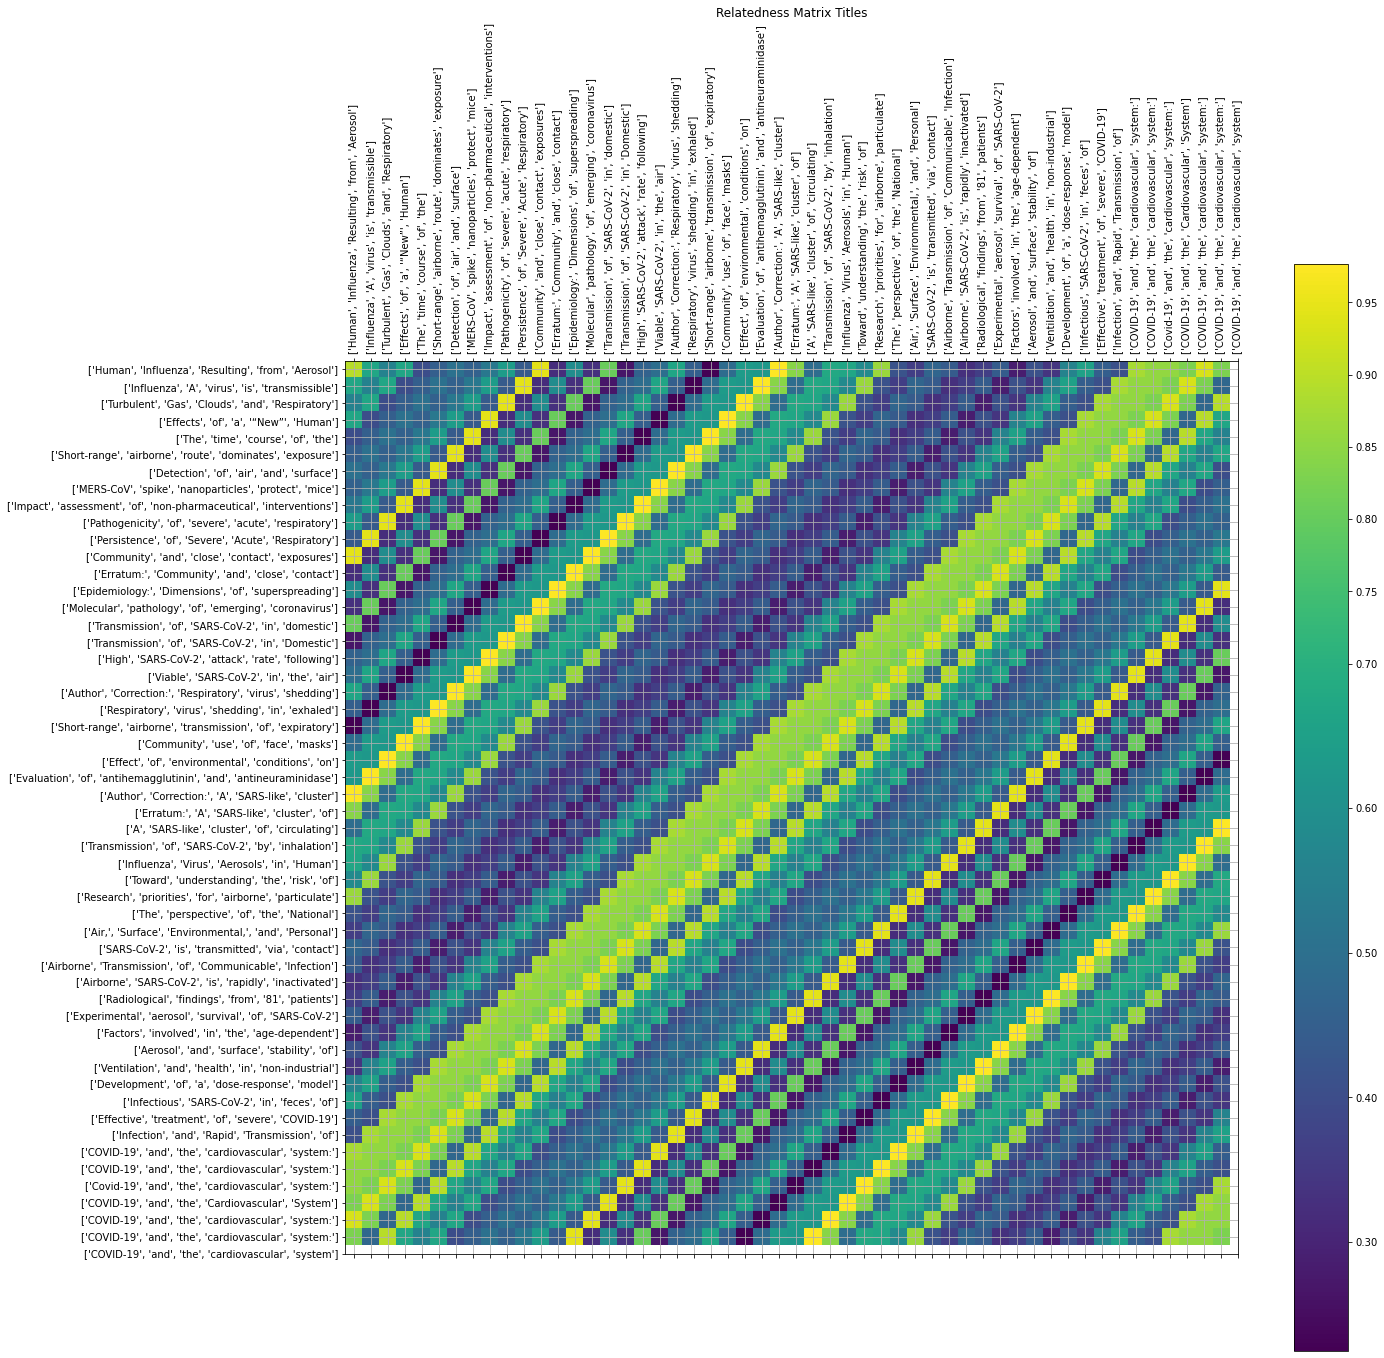

In [14]:
plot_matrix(title_list, relatedness_matrix_titles)

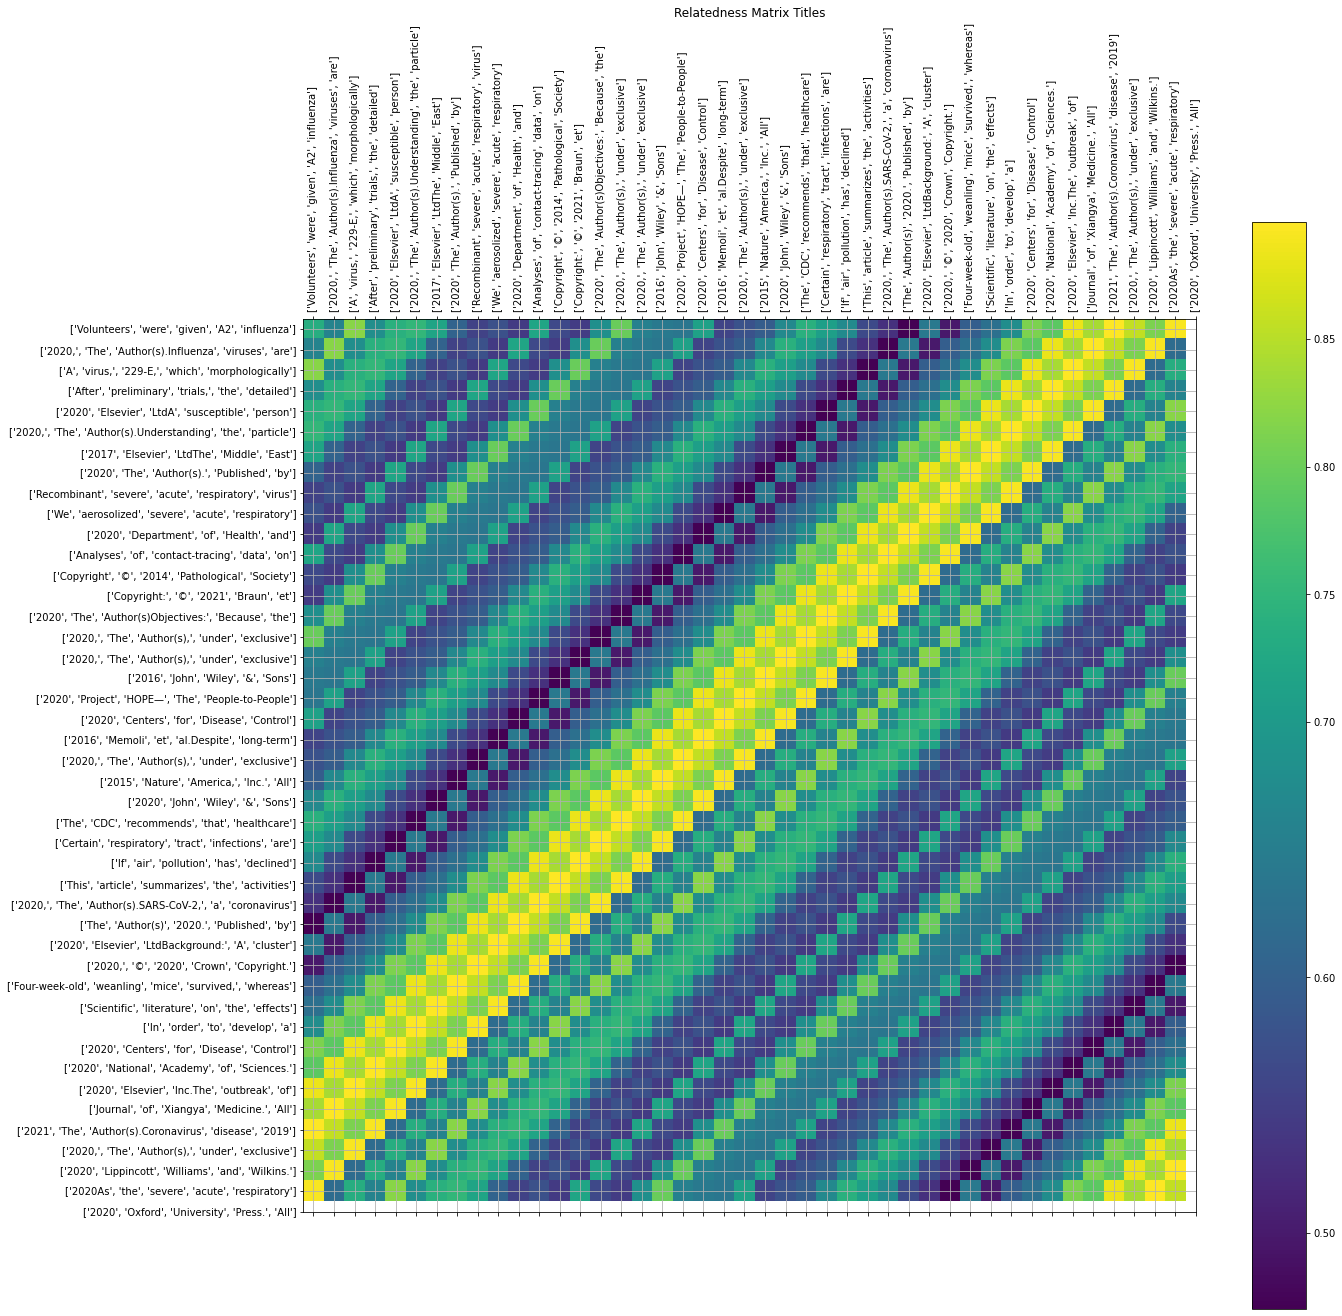

In [15]:
plot_matrix(abstract_list, relatedness_matrix_abstract)